In [1]:
import numpy as np
import matplotlib.pyplot as plt

loading precomputed roc-auc

In [21]:
a=np.load('preds/binary_atromnetv_roc.npy', allow_pickle=True)

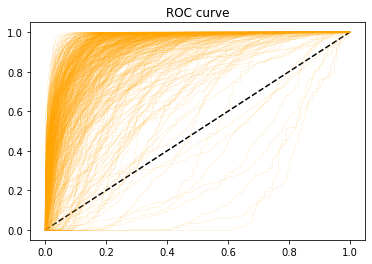

In [22]:
labels=['0','A','G','C','T']

if a.shape[2]==1:
    plt.title('ROC curve')
    plt.plot([0, 1], [0, 1],linestyle="--", color='black')
    for k in range(a.shape[0]):
        plt.plot(a[k,0,0],a[k,1,0],color='orange',linewidth=1,alpha=0.1)
    plt.show()
else:
    fig, ax=plt.subplots(2,3, figsize=(15,10))
    for i in range(5):
        for k in range(a.shape[0]):
            ax[i//3,i%3].plot(a[k,0,i],a[k,1,i])
        ax[i//3,i%3].plot([0, 1], [0, 1],linestyle="--", color='black')

parse logfile

In [17]:
with open('log.txt') as f:
    log_info=f.readlines()
    
log_dict={}
for string in log_info:
    if string[:9]=='Arguments':
        task_name=string[string.index('experiment_name'):].split("'")[1]
        print(task_name)
        log_dict[task_name]={'train loss':[],'val loss':[],'test loss':[],
                             'train auc':[],'val auc':[],'test auc':[]}
    if string[:10]=='Loss Train':
        log_dict[task_name]['train loss'].append(float(string.split()[-1]))
    elif string[:8]=='Loss Val':
        log_dict[task_name]['val loss'].append(float(string.split()[-1]))
    elif string[:9]=='Loss Test':
        log_dict[task_name]['test loss'].append(float(string.split()[-1]))
    elif string[:13]=='ROC-AUC Train':
        log_dict[task_name]['train auc'].append(float(string.split()[-1]))
    elif string[:11]=='ROC-AUC Val':
        log_dict[task_name]['val auc'].append(float(string.split()[-1]))
    elif string[:12]=='ROC-AUC Test':
        log_dict[task_name]['test auc'].append(float(string.split()[-1]))

npi_atomnetv_focal_0
npi_atomnetv_focal_0.5
npi_atomnetv_focal_1
npi_atomnetv_focal_2
npi_atomnetv_focal_5


In [18]:
for k in log_dict:
    print('Max roc-auc for',k, max(log_dict[k]['val auc']))
    

Max roc-auc for npi_atomnetv_focal_0 0.6795080311392483
Max roc-auc for npi_atomnetv_focal_0.5 0.6803163176665178
Max roc-auc for npi_atomnetv_focal_1 0.6795437770349084
Max roc-auc for npi_atomnetv_focal_2 0.680844733000836
Max roc-auc for npi_atomnetv_focal_5 0.6799330898672179


In [3]:
log_dict.pop('orig_v_drop')
log_dict.pop('orig_dgcnn')
log_dict.pop('orig_v')
log_dict.pop('orig')
log_dict.pop('orig_mp')

{'train loss': [0.5863174049489533,
  0.5421063686484722,
  0.5355188260661132,
  0.5279748473761242,
  0.5281077930842762,
  0.5199515706623223,
  0.516724439437932,
  0.5136456838961857,
  0.5120633609926523,
  0.5144038330930383,
  0.5084698873057739,
  0.5234983349302367,
  0.514073229308671,
  0.5134612833775246,
  0.509460883965688,
  0.5075303956199048,
  0.5055139014135991,
  0.5040283130565241,
  0.5030047483631035,
  0.5060508706064811,
  0.5012011388177747,
  0.4982883371412754,
  0.496454649524235,
  0.493905880847084,
  0.4929526265265782,
  0.4915933259443116,
  0.4915550435601331,
  0.48939073121369775,
  0.4882548564739192,
  0.4865922681097664,
  0.48740764991449775,
  0.48541576747240417,
  0.4850776494661374,
  0.48415173160940855,
  0.48263895427113146,
  0.48277072776386987,
  0.4814833898597689,
  0.48151766131840534,
  0.48030664099574977,
  0.47971309916074595,
  0.47926189292833876,
  0.47945680725596734,
  0.47876465850468003,
  0.47868474881484435,
  0.478023

show plots

In [4]:
colors=['red','blue','green','orange','purple','yellow']

/home/domain/data/prog/miniconda3/envs/dmasif/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


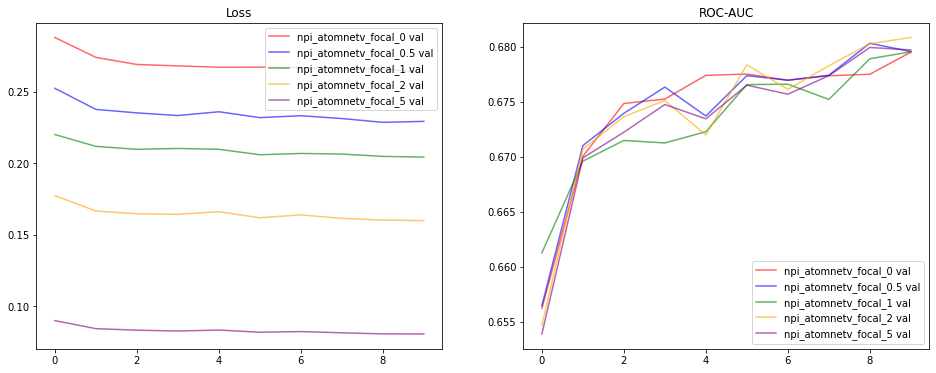

In [20]:
fig, ax=plt.subplots(1,2 , figsize=(16,6))
ax[0].set_title('Loss')
ax[1].set_title('ROC-AUC')

for i, k in enumerate(log_dict):
    #ax[0].plot(log_dict[k]['train loss'], color=colors[i], alpha=1,label=k+' train')
    ax[0].plot(log_dict[k]['val loss'], color=colors[i], alpha=0.6,label=k+' val')
    #ax[0].plot(log_dict[k]['test loss'], color=colors[i], alpha=0.3,label=k+' test')
    #ax[1].plot(log_dict[k]['train auc'], color=colors[i], alpha=1,label=k+' train')
    ax[1].plot(log_dict[k]['val auc'], color=colors[i], alpha=0.6,label=k+' val')
    #ax[1].plot(log_dict[k]['test auc'], color=colors[i], alpha=0.3,label=k+' test')  
ax[0].legend()
ax[1].legend()
fig.show()

Max roc-auc for binary_dgcnn 0.7716083364077496
Max roc-auc for binary_atomnet 0.9074962983309375
Max roc-auc for binary_atomnet_mp 0.9400463630153464
Max roc-auc for binary_atromnetv 0.9251051725638855
